# Assignment 3 - Monte Carlo Methods

<div class="alert alert-info">
    <b>Due date:</b> See MOODLE.
</div>

<div class="alert alert-info">

In the third assignment, you will implement algorithms that were presented in the lectures on Monte Carlo methods. You can gain 15 points in total. Please make sure that you do not overlook any of the questions.

<br>

For this assignment we will use OpenAI Gym (https://github.com/openai/gym), the OpenAI Black Jack environment and an updated version of the `Fishlake` environment. Please make sure you are using the `fishlake_updated.py` that is distributed along with the current assignment.

<br>

To solve this exercise, read the notebook carefully from beginning to end and fill out coding parts and answer questions marked with **TODO**.

<br>

To make sure you do not forget any **TODO**s in this rather long notebook, here is a list:

- Implement Episode Generation (2 Points)
- Implement MC Policy Evaluation (6 Points)
- Implement MC On-Policy Control (6 Points)
- Analysis of MC on Fishlake (1 Point)

**Do not forget to reset the kernel, and run all the code cells, before saving and submitting the assignment!**

Some# Blackjack - A Model-free Environment, Monte Carlo Methods

Let us now try Monte Carlo methods on a model-free environment (where it is very hard / impossible to use Dynamic Programming). We will use the game of Black Jack, as presented in the lecture. In general, MC methods are model free, but you might have used some convenience functions

<div class="alert alert-info">

The following description is adapted from the environment description at https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py:

    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over. They're playing against dealer
    that follows a fixed strategy.
    
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    
    This game is played with an infinite deck (drawing with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.
    
    If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.
    
    The reward for winning is +1, drawing is 0, and losing is -1.
    
    The observation is a 3-tuple of:
    
    the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.

### Preliminaries

What follows are the imports, the instantiation of the BlackJack gym-environment, and the introduction of some helper functions. You will have to run these cells first, before starting to implement and run your algorithms.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gym
import fishlake_updated as fishlake
import blackjack_convenience as blackjack

from collections import defaultdict

np.set_printoptions(precision=4, suppress=True, threshold=200)

### Let's play some BlackJack...

In [2]:
# the BlackJack environment does **not** give access to the dynamics or the size of the state space
# so there is no (easy) way we can use dynamic programming here, we are forced to use model-free methods
# the BlackJack environment has no 'render()' function either --- printing the state encoding is enough
blackjack_env = gym.make('Blackjack-v0')

# we can query the size of the action space:
print('Size of the action space:', blackjack_env.action_space.n)

# we can (indirectly) query the size of the observation space:
print('Structure/sizes of the observation space:', blackjack_env.observation_space)

# we can seed the PRNG of the environment for:
# - reproducability
# - easier debugging
# the PRNG is used by the environment to determine the order of the cards
blackjack_env.seed(1234)

# to reset the environment into its inital state, we can call 'reset()'
state = blackjack_env.reset()

# let's look at the components of the state encoding of the initial state
print(state)

Size of the action space: 2
Structure/sizes of the observation space: Tuple(Discrete(32), Discrete(11), Discrete(2))
(20, 3, False)


### The state encoding desugars into this ...

In [3]:
(player_score, dealer_score, usable_ace) = state

 ... but this is not really important for us!
Because the state is already a tuple, we will just use this tuple as a key into several dictionaries. They will store various value function approximations, policies, as well as support data.

## Defining Default BlackJack Policies

What follows are functions that generate basic policies.

In [4]:
# we include here the example policy that was also used in class:
def create_example_policy():
    """
    Create a policy that sticks if the player score is >= 20 and hits otherwise.
    """
    policy = dict()
    for score in range(4, 22):  # 4 - 21
        for dealer_score in range(1, 11):  # 1 - 10
            for useable_ace in [True, False]:
                observation = (score, dealer_score, useable_ace)
                if score >= 20:
                    # stick
                    policy[observation] = np.array([1.0, 0.0])
                else:
                    # hit
                    policy[observation] = np.array([0.0, 1.0])
    return policy

# and the random policy that chooses an action with equal probability
def create_random_policy():
    """
    Create the random policy.
    """
    policy = dict()
    
    for score in range(4, 22):
        for dealer_score in range(1, 11):
            for useable_ace in [True, False]:
                observation = (score, dealer_score, useable_ace)
                policy[observation] = np.array([0.5, 0.5])   
    return policy

---
## (1) Episode Generation (2 Points)
Here, you will define a helper function that will generate an episode, given an environment and a policy.

In [5]:
def generate_episode(rng, env, policy):
    # implement a helper function to generate an episode, given an environment and a policy
    # an episode is a list of (state, action, reward) tuples:
    # episode = [
    #    (state_1, action_1, reward_2),
    #    (state_2, action_2, reward_3),
    #    ...
    #    (state_T-1, action_T-1, reward_T)
    # ]
    
    actions = np.arange(env.action_space.n)
    episode = []
    done = False
    blackjack = True
    try: # blackjack_env
        state = env.reset()
        player_sum, bank_sum, player_ace = state
    except: # small_lake_env
        state = int(env.reset()) #render()
        location = state
        blackjack = False
        
    
    while not done:
        if blackjack == False: # use lake env
            policy_dict = policy #create_example_policy() for example
            action_array = policy_dict[state]
            
            action_array = np.random.multinomial(1, action_array) 
            # draw one action by considering the probabilities for the single actions
            
            action = np.where(action_array==1)[0][0]
            
            real_prob_of_happening_action = env.P[state][action]
            
            prob_list = []
            for single_prob in real_prob_of_happening_action:
                prob_list.append(single_prob[0])
                
            happen_array = np.random.multinomial(1, prob_list)
            happen_array_mask = happen_array.astype('bool')
      
            happen_action = (np.array(real_prob_of_happening_action)[happen_array_mask])[0]
            
            next_state, reward = int(happen_action[1]), happen_action[2]
            
            
            # check if next state is a rock:
            next_row, next_col = env.s2rc[next_state]
            field = env.desc
            
            if field[next_row][next_col] == b'R': # next field would be a rock
                next_state = state # we stay at old state
         
            episode.append((state, action, reward)) 
            
            
            if abs(reward) == 1: # it is -1 or 1
                return episode
            
            state = next_state
            
                   
        else: # blackjack
            if len(episode) != 0:
                state = (player_sum,bank_sum,player_ace)
       

            policy_dict = policy #create_example_policy() for example
            action_array = policy_dict[state]

            action_array = np.random.multinomial(1, action_array) 
            # draw one action by considering the probabilities for the single actions

            action = np.where(action_array==1)[0] 
            
         

            episode.append([state, action, 0]) # reward = 0

            # determine next state:
            # draw a card. prng determines the order of cards, drawing with replacement!
            if action == 0: # stick

                open_hidden_card = rng.integers(low=1, high=13) # bank draws a card # "high"-value excluded
                if open_hidden_card > 10:
                    open_hidden_card = 10

                bank_sum_added = bank_sum + open_hidden_card
                while bank_sum_added < 17:
                    next_card = rng.integers(low=1, high=13) # bank draws a card # "high"-value excluded
                    if next_card > 10:
                        next_card = 10

                    bank_sum_added += next_card

                if bank_sum_added > 21:
                    episode[-1][2] = 1
                    return episode


                if bank_sum_added > player_sum:
                    reward = -1
                elif bank_sum_added < player_sum:
                    reward = 1
                else: 
                    reward = 0

                episode[-1][2] = reward 
                # of the last state-action pair we change the reward to the final outcome of the game
                return episode


            if action == 1: # hit, player draws card, check ploicy for next state
                bank_sum_added = bank_sum


                player_next_card_value = rng.integers(low=1, high=13) # bank draws a card
                if player_next_card_value > 10:
                    player_next_card_value = 10
                 

                elif player_next_card_value ==1: # player draws an ace
                    if (player_sum +11) <= 21:
                        player_sum += 10 # the +1 of 11 is later added below
                        player_ace = True
                
                player_sum += player_next_card_value


                if player_sum > 21: # bust
                   
                    episode[-1][2] = -1

                    return episode

      

## (2) Monte Carlo Evaluation (6 Points)
Ler's get started: implement the every-visit MC policy evaluation algorithm.

In [6]:
def mc_policy_evaluation(rng, env, policy, n_episodes, gamma=1.0, n_print_every=10 ** 4):
    """
    Monte Carlo prediction algorithm, which calculates the value function
    for a given policy
    
    Args:
        env: the openai gym environment
        policy: the policy to be evaluated
        n_episodes: number of episodes to sample
        gamma: the discount factor
    
    Returns:
        the value function associated with 'policy'
    """
    # a note on the value function estimate 'V', 'G_sum' and 'G_count':
    # those functions must be stored as a 'dict' or 'defaultdict', where
    #
    # 'key' is a tuple encoding the state (player_sum, dealer_sum, useable_ace)
    #
    # and
    #
    # 'value' is the value of this state
    #
    # print(V) should yield something similar to this (except for the actual numerical values):
    #
    #     defaultdict(float,
    #             {(21, 10, True): 0.8863134657836644,
    #              (7, 10, False): -0.563816604708798,
    #              (11, 10, False): -0.10879368658399098,
    #              (20, 10, False): 0.43548387096774194,
    #              (13, 7, True): -0.3431372549019608,
    #              (12, 7, False): -0.5573080967402734,
    #              (21, 7, False): 0.9257294429708223,
    #              (13, 6, False): -0.5404255319148936,
    #              (19, 6, False): -0.6908077994428969,
    #              ...})
    #
    # please make sure you use this format, as only then the very convenient plotting function will work
    # 
    #
    # defaultdict only difference to dict: for searched keys that don't exist we get always an default value
    # instead of an error message!!
    #
    # for more info checkout the documentation on 'defaultdict':
    # https://docs.python.org/3/library/collections.html?highlight=defaultdict#collections.defaultdict
    #
    # if this is too much voodoo for you, you can use 'dict', but you have to do extra steps there
    # in case a key does not exist in the dictionary yet!
    G_sum = defaultdict(lambda: 0.) # default value in brackets # G_sum as S(s) container
    G_count = defaultdict(lambda: 0.) # G_count as N(s) container
        
    for i_episode in range(1, n_episodes + 1):
        if i_episode % n_print_every == 0:
            print("\rEpisode {}/{}.".format(i_episode, n_episodes))

        # TODO: generate an episode
        one_episode = generate_episode(rng, env, policy)

        # TODO: compute return G, update G_sum, G_count
        # For each state return G:
        # G is the cumulative discounted reward:
        
       
        first_ = True
        # aims for: [G_1, G_2, ...]
        
        for single_moment in reversed(one_episode):

            single_state_reward = single_moment[2]

            if first_ == True:
                
                single_state_G = single_state_reward
                single_state_G_array = np.array([single_state_G] ) 
                first_ = False
            
            else:
              
                single_state_G = single_state_reward + gamma * single_state_G_array[0] #np.sum(single_state_G_array)

                single_state_G_array = np.concatenate((single_state_G, single_state_G_array),axis=None)



            # let's come to look after the single state in G_sum and G_count
            single_state = single_moment[0]
            
            G_sum[single_state] += single_state_G # even if key doesn't exist we can create one by
            # adding an value to the default value
            G_count[single_state] += 1
                
            
            
    V = defaultdict(lambda: 0.)
    # TODO: compute the value function estimate 'V' from 'G_sum' and 'G_count'
    for single_key in G_sum: # .items() refer to keys AND values
       
        try:
            V[single_key] = G_sum[single_key]/G_count[single_key]
        except:
            V[single_key] = 0
    
    return V

### Run MC Policy Evaluation for Black Jack
Okay, let's now run the implemented algorithm on the Black Jack environment. You already know from the lecture slides what the output should roughly look like.

In [7]:
# let's create the example policy
example_policy = create_example_policy()

# TODO: for debugging, it might be a good idea to set this to a smaller value -> only temporarily though!
# set it back to (5 * 10 ** 4) before you re-run and submit your notebook!
n_episodes = 5 * 10 ** 4

seed_sequence = np.random.SeedSequence(1234)
rng = np.random.default_rng(seed_sequence)

# and now let's see how good the example policy really is
policy_value = mc_policy_evaluation(rng, blackjack_env, example_policy, n_episodes=n_episodes)

Episode 10000/50000.
Episode 20000/50000.
Episode 30000/50000.
Episode 40000/50000.
Episode 50000/50000.


<Figure size 432x288 with 0 Axes>

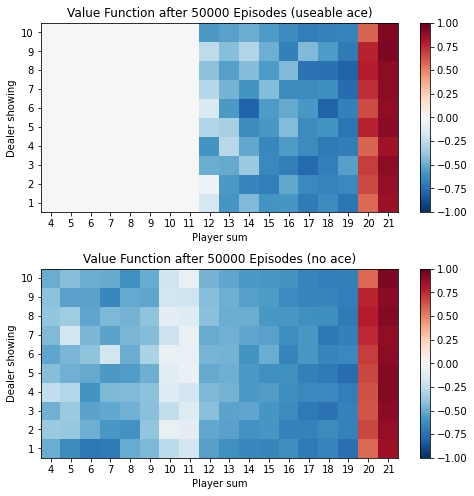

In [8]:
blackjack.plot_value_function(policy_value, title=f"Value Function after {n_episodes} Episodes")

## (3) Monte Carlo Control (6 Points)
Implement the On-policy every-visit MC control for ε-soft policies algorithm.

In [9]:
def mc_control_epsilon_greedy(rng, env, initial_policy, n_episodes=100, gamma=1.0, epsilon=0.1, n_print_every=10 ** 4):
    """
    On-policy every-visit MC control for ε-soft policies algorithm
    Computes an optimal epsilon-greedy policy.
    
    Args:
        env: the openai gym environment
        initial_policy: the inital policy as a dict with the state as the key,
                        and the values being numpy arrays that store the
                        action selection probabilities
        n_episodes: number of episodes to sample
        gamma: the discount factor
        epsilon: chance to sample a random action
    
    Returns:
        a tuple (policy, Q)
        opt_policy is a dict in the same format as the initial_policy
        Q is a dict with the state as the key,
        and an np.array as value, which contains the state-action values
"""
    
    # see the note on datastructures in 'mc_policy_evaluation(...)'!
    G_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    G_count = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # make a copy of the inital policy (it's bad style to change input parameters)
    policy = {k: v.copy() for k, v in initial_policy.items()}
    
    
    for i_episode in range(1, n_episodes + 1):
        if i_episode % n_print_every == 0:
            print("\rEpisode {}/{}.".format(i_episode, n_episodes))
        
        # TODO: generate an episode
        one_episode = generate_episode(rng, env, policy) # from task 2 
    
        # TODO: compute return G, update G_sum, G_count, and Q
     
        
        number_actions = env.action_space.n #len(np.arange(env.action_space.n))
   
        first_ = True
        # aims for: [G_1, G_2, ...]
        
        for single_moment in reversed(one_episode):

            single_state_reward = single_moment[2]
            single_action = single_moment[1]
            single_state = single_moment[0]
          
            if first_ == True:
                
                single_state_G = single_state_reward
                
                
                
                single_state_G_array = np.array([single_state_G] ) 
                first_ = False
            
            else:
              
                single_state_G = single_state_reward + gamma * single_state_G_array[0] #np.sum(single_state_G_array)
               

                single_state_G_array = np.concatenate((single_state_G, single_state_G_array),axis=None)



            # let's come to look after the single state in G_sum and G_count
            single_state = single_moment[0]


            G_sum[single_state][single_action] += single_state_G # even if key doesn't exist we can create one by
            # adding an value to the default value
            G_count[single_state][single_action] += 1
            
    
        for single_key in G_sum: # .items() refer to keys AND values
           # for single_action in actions:
            Q_array = G_sum[single_key]/G_count[single_key]
            Q_array[np.where(Q_array == float('inf'))] = 0 # for values where we 
            # divided by 0
            Q[single_key] = Q_array

            # TODO: derive an epsilon-soft policy from Q
            max_Ga_index = np.argmax(Q[single_key])
            policy[single_key] = np.array([epsilon/env.action_space.n]*env.action_space.n)
            policy[single_key][max_Ga_index] += 1 - epsilon
        

    
    return policy, Q

### Run MC Control for Black Jack
Finally, let's compute a better policy for the Black Jack game. One hint: the results may differ slightly from the lecture slides. They will also be different from the optimal policies in the book, as the ones in the book were computed with 'Exploring Starts'. Do not worry too much about it, but you can always try with a few more samples...

In [10]:
# here, we start from the example policy
# policy = create_example_policy()
n_episodes = 10 ** 5
n_print_every = 10 ** 4
initial_policy = create_random_policy()

# and now run our MC control algorithm
opt_policy, opt_Q = mc_control_epsilon_greedy(
    rng,
    blackjack_env,
    initial_policy,
    n_episodes=n_episodes,
    epsilon=0.1,
    n_print_every=n_print_every
)

# determine how good our policy is, in terms of v(s)
opt_V = mc_policy_evaluation(
    rng,
    blackjack_env,
    opt_policy,
    n_episodes=n_episodes,
    n_print_every=n_print_every
)

/tmp/ipykernel_15566/3730587686.py:84: RuntimeWarning: invalid value encountered in true_divide
  Q_array = G_sum[single_key]/G_count[single_key]


Episode 10000/100000.
Episode 20000/100000.
Episode 30000/100000.
Episode 40000/100000.
Episode 50000/100000.
Episode 60000/100000.
Episode 70000/100000.
Episode 80000/100000.
Episode 90000/100000.
Episode 100000/100000.
Episode 10000/100000.
Episode 20000/100000.
Episode 30000/100000.
Episode 40000/100000.
Episode 50000/100000.
Episode 60000/100000.
Episode 70000/100000.
Episode 80000/100000.
Episode 90000/100000.
Episode 100000/100000.


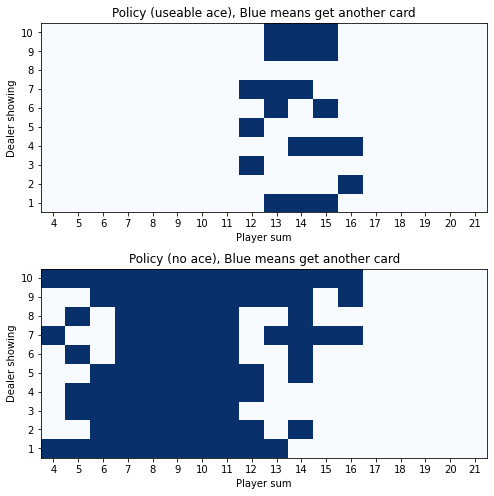

<Figure size 432x288 with 0 Axes>

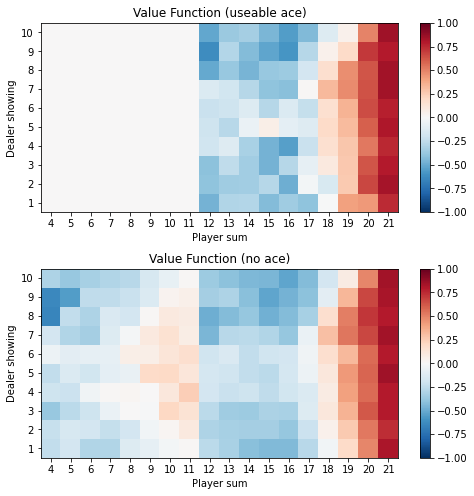

In [11]:
# plot the policy
blackjack.plot_policy(opt_policy)

# and its associated value function
blackjack.plot_value_function(opt_V)

---
# Fishlake Revisited with Monte Carlo methods
We will now go back to the Fishlake and run the MC algorithms on this problem. You will need to answer a textual question, after you tried MC on the Fishlake environment.

In order to run MC, we will need a few convenience functions for converting a value function and policy (a dict in the MC algorithms) to arrays, so we can re-use the existing plotting functions for the Fishlake environment.

In [12]:
def d2a_policy(env, policy):
    policy_array = np.zeros((env.observation_space.n, env.action_space.n))
    for state, ap in policy.items():
        policy_array[state, :] = ap
    return policy_array

def d2a_V(env, V):
    V_array = np.zeros(env.observation_space.n)
    for state, value in V.items():
        V_array[state] = value
    return V_array

def fishlake_random_policy(env):
    policy = defaultdict()
    for state in range(env.observation_space.n):
        policy[state] = np.ones(env.action_space.n) / env.action_space.n
    return policy    

## Run MC Evaluation on Fishlake

In [13]:
# we start with the smaller lake
small_lake_env = gym.make('FishlakeStreamy-v0')
small_lake_env.seed(1234)

# let's create a random policy
random_policy = fishlake_random_policy(small_lake_env)

# and now let's see how good our policy is
rng = np.random.default_rng(4321)
V_dict = mc_policy_evaluation(rng, small_lake_env, random_policy, 200)

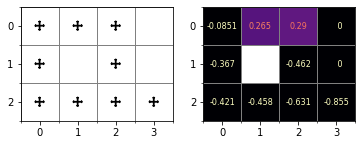

In [14]:
# let's plot this
random_policy_array = d2a_policy(small_lake_env, random_policy)
V_array = d2a_V(small_lake_env, V_dict)

fig, axes = plt.subplots(ncols=2)
fishlake.plot_policy(axes[0], small_lake_env, random_policy_array)
fishlake.plot_value_function(axes[1], small_lake_env, V_array)
plt.show()

## Run MC Control on Fishlake

In [15]:
# we start with the smaller lake
small_lake_env = gym.make('FishlakeStreamy-v0')
small_lake_env.seed(1234)

# let's create a random policy
initial_policy = fishlake_random_policy(small_lake_env)
rng = np.random.default_rng(4321)
opt_policy, opt_Q = mc_control_epsilon_greedy(
    rng,
    small_lake_env,
    initial_policy,
    n_episodes=10 ** 4,
    epsilon=0.1
)

# and now let's see how good our policy is
opt_V = mc_policy_evaluation(rng, small_lake_env, opt_policy, n_episodes=10 ** 4)

/tmp/ipykernel_15566/3730587686.py:84: RuntimeWarning: invalid value encountered in true_divide
  Q_array = G_sum[single_key]/G_count[single_key]


Episode 10000/10000.
Episode 10000/10000.


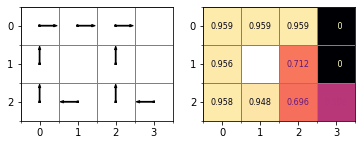

In [16]:
# let's plot this
opt_policy_array = d2a_policy(small_lake_env, opt_policy)
opt_V_array = d2a_V(small_lake_env, opt_V)

fig, axes = plt.subplots(ncols=2)
fishlake.plot_policy(axes[0], small_lake_env, opt_policy_array)
fishlake.plot_value_function(axes[1], small_lake_env, opt_V_array)
plt.show()

### (4) Differences DP/MC (1 Point)
Compare the results from MC Evaluation and Control with the results you got via dynamic programming in the last exercise. What could be the reasons for the differences you are seeing?

Answer: MC isn't aware of the dynamics. So it doesn't recognize that with a certain probability you end up in an other state than ordered. However, what the MC observed is that effect but it doesn't learn something about the probabilities that streaming in other direction than wanted will really happen. Also the reward function is unknown for MC.